In [ ]:
import boto3
import time

params = {
    'region': 'us-east-1',
    'database': 'clinicaltrial',
    'bucket': 'c47145a661226l1736519t1w518488174287-s3bucket-17tif1fihjb6m',
    'path': 'AthenaResult/DBCreation/',
    'aws_access_key_id': '****',
    'aws_secret_access_key': '****',                
    'aws_session_token': 'FwoGZXIvYXdzEJT//////////wEaDMQrOtNDPKDTZg2wOiLJAZDhHVIWvY+zp6kpxoCjGQMcU5kBEjst2bpewsOcWPgKE4Ys+vnizfhtJktJ/6Ww/+3/BIO/LxHDZ6Q3fWc70x3Cvrf70Z0zDuy5HY1OvFkZNi/XAUWg1uwpJsNaKlmOiZf4JrQrTY3wp4xC09Z6c5R8Sru6Dfuc7n5GX13VbTovRDHc3CvEkjc0Imp0VwCMhOKJfxOI8/KM6sXd264Vxk9OWGjF9D6DP+aB0NyDZScrYqV4Qvx6AGxJqKj+9mBpPgsiTMj9OMGEjiid6/iTBjItQcie1ykT8E+YyvtzAuw+WnuTpw62wn5yntN0mqDY42TSJ8N9XlmyONqjmHEd',
    'resFileName':'athena_results.csv'
}

client = boto3.client('athena', 
    aws_access_key_id = params["aws_access_key_id"], 
    aws_secret_access_key = params["aws_secret_access_key"], 
    aws_session_token = params["aws_session_token"],
    region_name = 'us-east-1' )

s3 = boto3.resource('s3',
    aws_access_key_id = params["aws_access_key_id"], 
    aws_secret_access_key = params["aws_secret_access_key"], 
    aws_session_token = params["aws_session_token"],                    
    region_name = 'us-east-1')

In [ ]:
def athena_query(query,client, params):
    
    response = client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': params['database']
        },
        ResultConfiguration={
            'OutputLocation': 's3://' + params['bucket'] + '/' + params['path']
        }
    )
    return response

In [ ]:
def athena_to_s3(query,client, params, max_execution = 5):
    execution = athena_query(query, client, params)
    execution_id = execution['QueryExecutionId']
    state = 'RUNNING'

    while (max_execution > 0 and state in ['RUNNING', 'QUEUED']):
        max_execution = max_execution - 1
        response = client.get_query_execution(QueryExecutionId = execution_id)

        if 'QueryExecution' in response and \
                'Status' in response['QueryExecution'] and \
                'State' in response['QueryExecution']['Status']:
            state = response['QueryExecution']['Status']['State']
            if state == 'FAILED':
                return False
            elif state == 'SUCCEEDED':
                s3_path = response['QueryExecution']['ResultConfiguration']['OutputLocation']
                filepath = s3_path.replace("s3://c47145a661226l1736519t1w518488174287-s3bucket-17tif1fihjb6m/",'')
                return filepath
        time.sleep(1)
    
    return False

In [ ]:
def gets3file(filepath):
    objects = s3.Object(bucket_name=params["bucket"],key=filepath)
    return objects.get()

In [ ]:
tmpFilePath = "/tmp/"+params["resFileName"]
dbfsFilePath = "/FileStore/athena/"
def saveToFile(response):
    with open(tmpFilePath,"wb") as binary_file:
        binary_file.write(response['Body'].read())
    try:
        dbutils.fs.mkdir(dbfsFilePath)
    except:
        pass
    dbutils.fs.cp("file://"+tmpFilePath,dbfsFilePath+params["resFileName"])
    

In [ ]:
def cleanup():
    my_bucket = s3.Bucket(params['bucket'])
    for item in my_bucket.objects.filter(Prefix=params['path']):
        item.delete()

In [ ]:
q1 = "select distinct count(*) from clinicaltrial_2021"
s3Path = athena_to_s3(q1, client, params)
response = gets3file(s3Path)
saveToFile(response)
dbfs_athena_results_path = dbfsFilePath + params["resFileName"]
dbutils.fs.head(dbfs_athena_results_path)

Out[16]: '"_col0"\n"387261"\n'

In [ ]:
q2 = "select Type,count(Type) as frequency from clinicaltrial_2021 group by Type order by frequency desc"
s3Path = athena_to_s3(q2, client, params)
response = gets3file(s3Path)
saveToFile(response)
dbfs_athena_results_path = dbfsFilePath + params["resFileName"]
resDF = spark.read.format("com.databricks.spark.csv").options(header=True).load(dbfs_athena_results_path)
display(resDF)

Type,frequency
Interventional,301472
Observational,77540
Observational [Patient Registry],8180
Expanded Access,69


In [ ]:
q3_0 = "create or replace view exploded_conditions as select condition from clinicaltrial_2021 cross join unnest(split(conditions,',')) as t(condition) where condition != ''"
s3Path = athena_to_s3(q3_0, client, params)

In [ ]:
q3 = "select condition, count(*) from exploded_conditions group by condition order by count(*) desc limit 5"
s3Path = athena_to_s3(q3, client, params)
response = gets3file(s3Path)
saveToFile(response)
dbfs_athena_results_path = dbfsFilePath + params["resFileName"]
resDF = spark.read.format("com.databricks.spark.csv").options(header=True).load(dbfs_athena_results_path)
display(resDF)

condition,_col1
Carcinoma,13389
Diabetes Mellitus,11080
Neoplasms,9371
Breast Neoplasms,8640
Syndrome,8032


In [ ]:
q4_0 = "create or replace view mesh_conditions as select * from mesh inner join exploded_conditions on mesh.term = exploded_conditions.condition"
s3Path = athena_to_s3(q4_0, client, params)

In [ ]:
q4 = "select root , count(*) as frequency from(select substr(tree,1,3) as root from mesh_conditions) group by root order by frequency desc limit 5"
s3Path = athena_to_s3(q4, client, params)
response = gets3file(s3Path)
saveToFile(response)
dbfs_athena_results_path = dbfsFilePath + params["resFileName"]
resDF = spark.read.format("com.databricks.spark.csv").options(header=True).load(dbfs_athena_results_path)
display(resDF)

root,frequency
C04,143994
C23,136079
C01,106674
C14,94523
C10,92310


In [ ]:
q5_0 = "create or replace view pharma_sponsor as select * from clinicaltrial_2021 left join pharma on clinicaltrial_2021.Sponsor = pharma.Parent_Company"
s3Path = athena_to_s3(q5_0, client, params)

In [ ]:
q5 = "select sponsor, count(*) as trials_offered from pharma_sponsor where parent_Company is null group by sponsor order by trials_offered desc limit 10"
s3Path = athena_to_s3(q5, client, params)
response = gets3file(s3Path)
saveToFile(response)
dbfs_athena_results_path = dbfsFilePath + params["resFileName"]
resDF = spark.read.format("com.databricks.spark.csv").options(header=True).load(dbfs_athena_results_path)
display(resDF)

sponsor,trials_offered
National Cancer Institute (NCI),3218
M.D. Anderson Cancer Center,2414
Assistance Publique - Hôpitaux de Paris,2369
Mayo Clinic,2300
Merck Sharp & Dohme Corp.,2243
Assiut University,2154
Novartis Pharmaceuticals,2088
Massachusetts General Hospital,1971
Cairo University,1928
Hoffmann-La Roche,1828


In [ ]:
q6_0 = "create or replace view trials as select completion, status, month,year from(select completion, status,substr(completion, 5, 8) as year, substr(completion,1,3) as month from clinicaltrial_2021) where completion != '' and status = 'Completed' and year = '2021'"
s3Path = athena_to_s3(q6_0, client, params)
q6_0_1 = "create or replace view monthly_completion_status as select month_in_num, month, total_Completed from(select substr(cast(date_parse(concat(month, '-', '01-', year),'%b-%d-%Y')as varchar),6,2) as month_in_num, month,count(*) as total_Completed from trials group by month,year order by month_in_num)"
s3Path = athena_to_s3(q6_0_1, client, params)


In [ ]:
q6 = "select month,total_Completed from monthly_completion_status"
s3Path = athena_to_s3(q6, client, params)
response = gets3file(s3Path)
saveToFile(response)
dbfs_athena_results_path = dbfsFilePath + params["resFileName"]
resDF = spark.read.format("com.databricks.spark.csv").options(header=True).load(dbfs_athena_results_path)
display(resDF)

month,total_Completed
Jan,1131
Feb,934
Mar,1227
Apr,967
May,984
Jun,1094
Jul,819
Aug,700
Sep,528
Oct,187


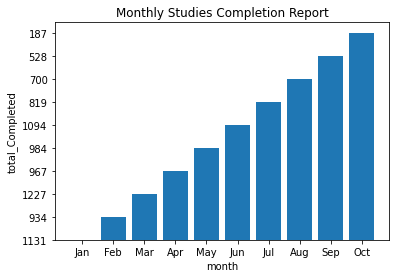

In [ ]:
import matplotlib.pyplot as plt

x_axis = resDF.toPandas()['month'].values.tolist()
y_axis = resDF.toPandas()['total_Completed'].values.tolist()

plt.ylabel('total_Completed')
plt.xlabel('month')
plt.title('Monthly Studies Completion Report')
plt.bar(x_axis,y_axis)

plt.show()

In [ ]:
cleanup()